In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train_df=pd.read_csv("train.csv")
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


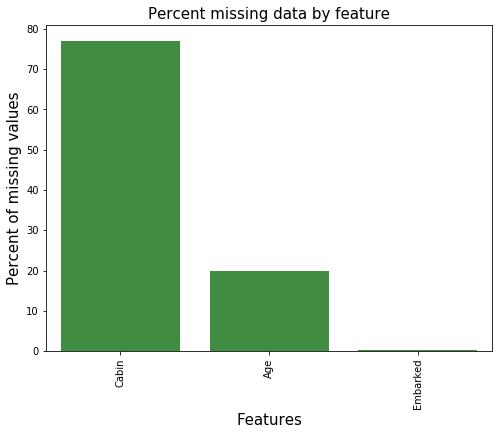

In [3]:
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    f,ax =plt.subplots(figsize=(8,6))
    plt.xticks(rotation='90')
    fig=sns.barplot(ms.index, ms["Percent"],color="green",alpha=0.8)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)
    return ms
missingdata(train_df)

In [4]:
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace = True)
train_df['Age'].fillna(train_df['Age'].median(), inplace = True)

In [5]:
drop_column = ['Cabin']
train_df.drop(drop_column, axis=1, inplace = True)

In [6]:
print('check the nan value in train data')
print(train_df.isnull().sum())

check the nan value in train data
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


In [7]:
dataset = train_df
dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
import re
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don','Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
dataset['Age_bin'] = pd.cut(dataset['Age'], bins=[0,14,20,40,120], labels=['Children','Teenage','Adult','Elder'])
dataset['Fare_bin'] = pd.cut(dataset['Fare'], bins=[0,7.91,14.45,31,120], labels=['Low_fare','median_fare', 'Average_fare','high_fare'])
                                                                               
traindf=train_df
drop_column = ['Age','Fare','Name','Ticket']
train_df.drop(drop_column, axis=1, inplace = True)
drop_column = ['PassengerId']
traindf.drop(drop_column, axis=1, inplace = True)
traindf = pd.get_dummies(traindf, columns = ["Sex","Title","Age_bin","Embarked","Fare_bin"],
                             prefix=["Sex","Title","Age_type","Em_type","Fare_type"])

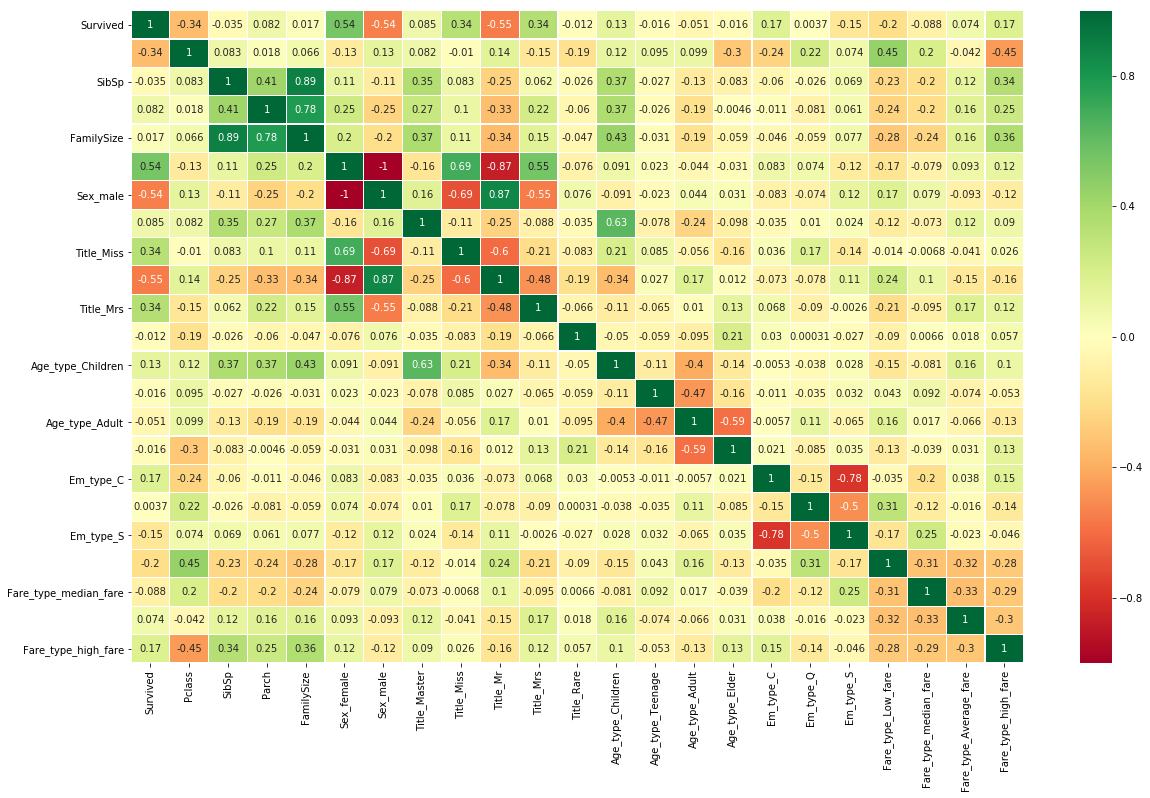

In [8]:
sns.heatmap(traindf.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

In [9]:
from sklearn.model_selection import train_test_split #for split the data
from sklearn.metrics import accuracy_score  #for accuracy_score
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn.model_selection import GridSearchCV
all_features = traindf.drop("Survived",axis=1)
Targeted_feature = traindf["Survived"]
X_train,X_test,y_train,y_test = train_test_split(all_features,Targeted_feature,test_size=0.3,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((623, 22), (268, 22), (623,), (268,))

--------------The Accuracy of the model----------------------------
('The accuracy of the Random Forest Classifier is', 82.09)
('The cross validated score for Random Forest Classifier is:', 83.51)


Text(0.5,1.05,'Confusion_matrix')

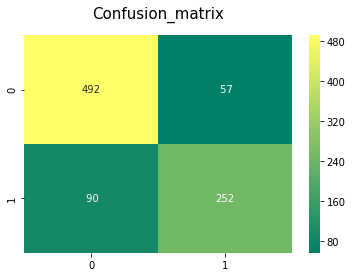

In [10]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(criterion='gini', n_estimators=700,
                             min_samples_split=10,min_samples_leaf=1,
                             max_features='auto',oob_score=True,
                             random_state=1,n_jobs=-1)
model.fit(X_train,y_train)
prediction_rm=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Random Forest Classifier is', round(accuracy_score(prediction_rm,y_test)*100,2))
kfold = KFold(n_splits=10, random_state=22) # k=10, split the data into 10 equal parts
result_rm=cross_val_score(model,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score for Random Forest Classifier is:',round(result_rm.mean()*100,2))
y_pred = cross_val_predict(model,all_features,Targeted_feature,cv=10)
sns.heatmap(confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

In [11]:
# Random Forest Classifier Parameters tunning 
model = RandomForestClassifier()
n_estim=range(100,1000,100)
## Search grid for optimal parameters
param_grid = {"n_estimators" :n_estim}
model_rf = GridSearchCV(model,param_grid = param_grid, cv=5, scoring="accuracy", n_jobs= 4, verbose = 1)
model_rf.fit(X_train,y_train)
# Best score
print(model_rf.best_score_)
#best estimator
model_rf.best_estimator_
print(model)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:   32.4s finished


0.8138041733547352
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
